In [ ]:
'''
Download the VisDrone 2019 Train Dataset (1.44 GB)
'''
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1a2oHjcEcwXP8oUF95qiwrqzACb2YlUhn" -O VisDrone2019-DET-train.zip && rm -rf /tmp/cookies.txt


'''
Download the VisDrone 2019 Valid Dataset (0.07 GB)
'''
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1bxK5zgLn0_L8x276eKkuYA_FzwCIjb59" -O VisDrone2019-DET-val.zip && rm -rf /tmp/cookies.txt


'''
Download the VisDrone 2019 Test Dataset  (0.28 GB)
'''
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1PFdW_VFSCfZ_sTSZAGjQdifF_Xd5mf0V' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1PFdW_VFSCfZ_sTSZAGjQdifF_Xd5mf0V" -O VisDrone2019-DET-test-dev.zip && rm -rf /tmp/cookies.txt

!unzip VisDrone2019-DET-train.zip
!unzip VisDrone2019-DET-val.zip
!unzip VisDrone2019-DET-test-dev.zip -d VisDrone2019-DET-test


In [1]:
'''
Import packages and define path and class information
'''
import os
import cv2
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import collections
import torch.optim as optim
from torchvision import transforms, datasets
from retinanet import model
from retinanet.dataloader import CSVDataset, collater, Resizer, AspectRatioBasedSampler, Augmenter, Normalizer
from torch.utils.data import DataLoader
from retinanet import csv_eval

assert torch.__version__.split('.')[0] == '1'



# utils contains a bunch of functions I defined to help preprocess the data
import utils


dir_train = 'VisDrone2019-DET-train'
dir_valid = 'VisDrone2019-DET-val'
dir_test = 'VisDrone2019-DET-test'
class_dict = {0: 'ignored-regions',
              1: 'pedestrian',
              2: 'people',
              3: 'bicycle',
              4: 'car',
              5: 'van',
              6: 'truck',
              7: 'tricycle',
              8: 'awning-tricycle',
              9: 'bus',
              10: 'motor',
              11: 'others'
              }



In [2]:
'''
Show the first 5 image and annotation paths
'''

train_imgs, train_labels = utils.get_dataset_paths(dir_train)
print(train_imgs[:5])
print(train_labels[:5])


['/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/images/0000002_00005_d_0000014.jpg', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/images/0000002_00448_d_0000015.jpg', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/images/0000003_00231_d_0000016.jpg', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/images/0000007_04999_d_0000036.jpg', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/images/0000007_05499_d_0000037.jpg']
['/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/annotations/0000002_00005_d_0000014.txt', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/annotations/0000002_00448_d_0000015.txt', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/annotations/0000003_00231_d_0000016.txt', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/annotations/0000007_04999_d_0000036.txt', '/home/test/pytorch-retinanet/Part1/VisDrone2019-DET-train/annotations/0000007_05499_d_0000037.txt']


First image:


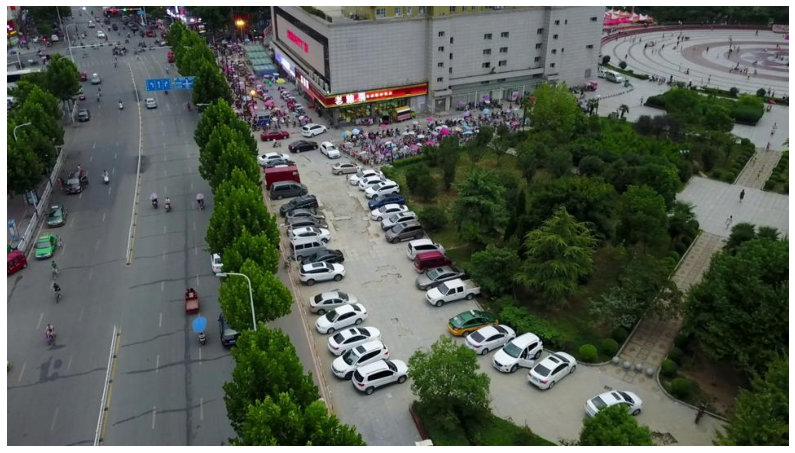

Annotation:
684,8,273,116,0,0,0,0
406,119,265,70,0,0,0,0
255,22,119,128,0,0,0,0
1,3,209,78,0,0,0,0
708,471,74,33,1,4,0,1
639,425,61,46,1,4,0,0
594,399,64,51,1,4,0,0
562,390,61,38,1,4,0,0
540,372,65,33,1,4,0,1
514,333,68,35,1,4,0,0
501,317,64,31,1,4,0,1
501,299,45,28,1,4,0,1
489,284,48,27,1,4,0,1
463,262,48,29,1,4,0,0
458,252,49,22,1,4,0,1
448,242,45,20,1,4,0,1
442,230,49,19,1,4,0,1
439,214,45,21,1,4,0,1
429,208,42,19,1,4,0,1
420,199,43,20,1,4,0,1
398,188,41,18,1,4,0,1
46,391,14,26,1,2,0,0
421,433,74,44,1,4,0,1
369,346,64,34,1,4,0,0
398,410,72,46,1,4,0,1
394,393,70,36,1,4,0,1
377,364,71,38,1,4,0,0
357,312,58,31,1,4,0,0
359,298,54,22,1,4,0,2
348,283,43,28,1,5,0,1
345,271,52,19,1,4,0,1
340,260,60,18,1,5,0,1
340,250,52,16,1,4,0,1
332,231,54,22,1,5,0,1
323,213,45,25,1,5,0,0
317,195,45,31,1,6,0,1
316,188,36,15,1,4,0,2
308,179,44,17,1,4,0,1
345,163,37,18,1,4,0,0
384,164,26,22,1,4,0,1
43,398,18,17,1,10,0,1
324,167,14,6,1,3,0,0
362,143,30,18,1,4,1,0
310,150,36,15,1,4,0,0
258,375,30,43,1,4,0,2
2

In [3]:
'''
Load first image as np array and show it
'''
first_img = cv2.imread(train_imgs[0])
first_img = cv2.cvtColor(first_img, cv2.COLOR_BGR2RGB)

print('First image:')
fig = plt.figure(num=1, figsize=(14, 14))
plt.imshow(first_img)
plt.xticks([]), plt.yticks([])
plt.axis('off')
plt.show()

'''
Show first annotation
'''
print('Annotation:')
with open(train_labels[0], 'r') as f:
    lines = f.readlines()
    for line in lines:
        print(line.strip())



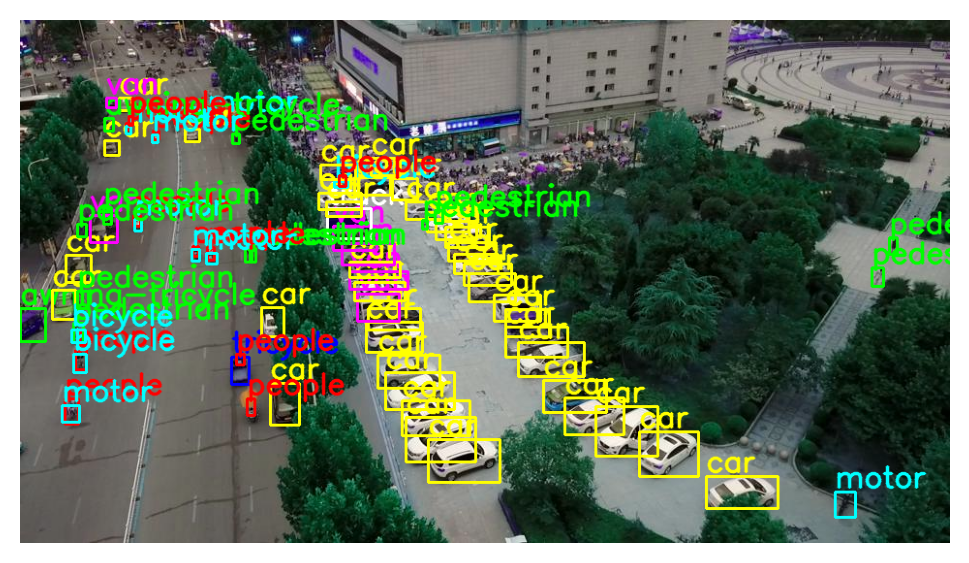

In [4]:
'''
Show first annotated image
'''

first_label = utils.create_label(train_labels[0])
im_np = utils.annotate_img(first_img, first_label, class_dict)


#### 2. Holdout dataset split as specified

The dataset comes split into three different folders - train, validation, and test. I need to put the images and annotations into CSV format for training. I will use approximately 1/4 of the size of each dataset.

In [5]:
'''
List the number of images in train, validation, and test sets
'''
!ls VisDrone2019-DET-train/images/ | wc -l
!ls VisDrone2019-DET-val/images/ | wc -l
!ls VisDrone2019-DET-test/images/ | wc -l

6471
548
1610


In [6]:
'''
Creae a CSV for each set
'''
utils.create_CSV(dir_train,1600,'train.csv',class_dict)
utils.create_CSV(dir_valid,150,'valid.csv',class_dict)
utils.create_CSV(dir_test,400,'test.csv',class_dict)

#### 3. Correct explanation generalization from such a holdout split

The train and validation sets are used when training the retinanet model. As the model trains, predictions are made on the validation set to determine the accuracy of the network. The holdout (aka test) set is used on to compare the effectiveness of final model against other models.

#### 4. Printout of dataset distribution, including missing data. For imagery datasets, provide the "average image" for each class. For tabular data, use `value_counts()` and `describe()`. For textual data, show the distribution of your labels/targets.

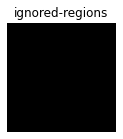

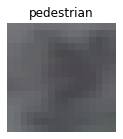

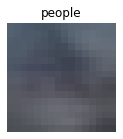

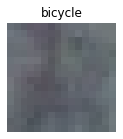

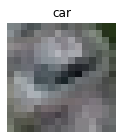

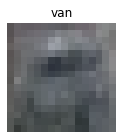

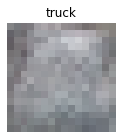

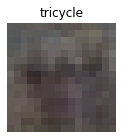

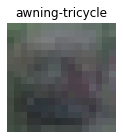

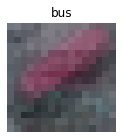

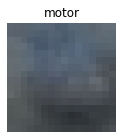

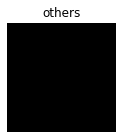

In [7]:
'''
Show the average class in the train set by averaging the bounding boxes from num_avg bounding boxes into a dim shapped image
'''
df_labels = pd.read_csv('train.csv')
df_labels.columns = ['img_path', 'x1', 'y1', 'x2', 'y2', 'label']
classes = class_dict.values()
dim = (16,16)
num_avg = 10

for c in classes:
    df_class = df_labels[df_labels['label'] == c]
    avg_class = np.zeros((num_avg,dim[0],dim[1],3),dtype=np.float64)

    i = 0
    for idx,row in df_class[:num_avg].iterrows():
        img = cv2.imread(row['img_path'])

        y1 = int(row['y1'])
        y2 = int(row['y2'])
        x1 = int(row['x1'])
        x2 = int(row['x2'])
        car = img[y1:y2,x1:x2]

        avg_class[i] = cv2.resize(car,dim)
        i+=1

    avg = np.array(np.mean(avg_class, axis=(0)), dtype=np.uint8)

    fig = plt.figure(figsize=(2,2))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(cv2.cvtColor(avg, cv2.COLOR_BGR2RGB))
    ax.axis('off')
    ax.set_title(c)

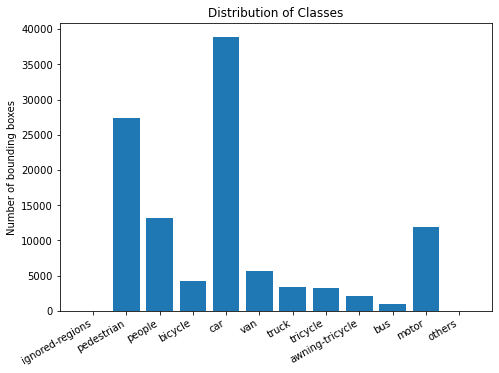

In [8]:
'''
Show a bar graph of distributions bounding boxes by class
'''
label_dist = {}
for c in classes:
    label_dist[c] = len(df_labels[df_labels['label'] == c])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(label_dist.keys(),label_dist.values())
ax.set_ylabel('Number of bounding boxes')
plt.title('Distribution of Classes')
plt.xticks(rotation=30, ha='right')
plt.show()


#### 5. Discussion of how the dataset distribution can/will affect your modeling.

There is a pretty substantial class imbalance. There are many pedestrian and car instances, so the model will be accurate when identifying them, but other classes, like awning-tricycle, might not be detected since there are a lot fewer of them for the model to train on.

#### 6. Handle any missing data. For imagery/text datasets, discuss what records/items you might drop and why.
This dataset did not have missing data as every image file had a corresponding annotation file.

The Retinanet model takes as inputs images and annotations when it is training. Both images and annotations can have issues. I will keep all images for now, and instead focus on getting clean annotations. The dataset lists several parameters for each image annotation. [Info from here](https://github.com/dronefreak/VisDrone-dataset-python-toolkit)

| Parameter       | Description                                                                  |
|-----------------|------------------------------------------------------------------------------|
| bbox_left       | The x coordinate of top-left corner of predicted bounding box                |
| bbox_top        | The y coordinate of the top-left corner of the predicted object bounding box |
| bbox_width      | The width in pixels of the predicted object bounding box                     |
| score           | The confidence of the ground truth bounding box instance 0 or 1              |
| object_category | Type of the annotated object 0-11                                            |
| truncation      | Indicates the degree of which the object appears outside image frame 0 or 1  |
| occlusion       | Indicates the fraction of object being occluded 0, 1, or 2                   |


Bounding boxes around objects that are occluded may be hard for the object to identify, same with truncation. Removing these from the dataset would likely improve accuracy of the model. However, the model would not perform well in the real world where objects may be naturally truncated or occluded. Therefore, it is best to leave the truncated and occluded bounding boxes in the dataset to have the model generalize well in real world environments.

The only bounding boxes I would drop are records who have a score == 0, since they have a low ground truth confidence.



#### 7. The holdout dataset also contains missing data/bad images/text. Discuss how you handled this in your holdout, or why it was not a problem for you.

The holdout dataset was not a problem for me, since I also used the same preprocessing steps as the train dataset - any bounding box annotation where the ground truth is 1 will be used, and any with 0 will be ignored.

#### 8. Discuss (and implement if applicable) whether or not you need to scale/normalize your features, and which ones, if any, for tabular data or imagery. For textual data, display the outputs of the word embeddings and discuss why they look the way they do.

I will normalize the pixel values of the image so that the mean and standard deviation of the image match the mean and standard deviation of the dataset. Also I will scale the dimensions of the input image so it matches the input dimension of the model.

In [10]:
'''
Normalize image pixel values based on the mean and standard deviation of the dataset
'''

# calculate the mean and std of the dataset using downsampled images in the DataLoader
# Source: https://www.binarystudy.com/2021/04/how-to-calculate-mean-standard-deviation-images-pytorch.html
batch_size = 2
temp_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(256),
    transforms.ToTensor()])

image_data = datasets.ImageFolder(root=dir_train, transform=temp_transform)

loader = DataLoader(
  image_data,
  batch_size = batch_size,
  num_workers=1)

def batch_mean_and_sd(loader):

    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in loader:
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels

    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)
    return mean,std

mean, std = batch_mean_and_sd(loader)
mean = mean.tolist()
std = std.tolist()
print('mean:')
print(mean)
print('std:')
print(std)

normalizer = Normalizer(mean, std)

'''
Scale images to match the input dimensions of the model
'''
resizer = Resizer(min_side=608, max_side=1024)

mean:
[0.38516947627067566, 0.39026349782943726, 0.3755533993244171]
std:
[0.22190919518470764, 0.22177447378635406, 0.2310042828321457]


#### 9. If your dataset has categorical features: discuss and implement if you will encode them as ordinal numbers, or one-hot encode them, and why you chose to do so for each such feature. If you are using images/text, discuss whether you are performing classification or regression on your dataset and why (instead of the other one).

The labels of each bounding box are encoded as ordinal numbers. They are labeled in the dataset with the following numbering scheme:
```
label_dict = {0: 'ignored-regions',
              1: 'pedestrian',
              2: 'people',
              3: 'bicycle',
              4: 'car',
              5: 'van',
              6: 'truck',
              7: 'tricycle',
              8: 'awning-tricycle',
              9: 'bus',
              10: 'motor',
              11: 'others'
              }
```
While I could one-hot encode the labels, the Retinanet model implemented in Pytorch outputs a tensor with ordinal labels (corresponding to the training set). Since this is how the model works internally, I will keep the labels as ordinal.


#### 10. Give an example of an ordinal feature that you've seen used by others, when it should have been treated as a categorical.
A model that tries to predict a persons favorite color based on the ice cream flavors they like. If the ice cream was one ordinal feature, then it might be encoded as 1: strawberry, 2: vanilla, 3: chocolate, ... This encoding is not good because there is no relationship between the value the flavor is assigned and the flavor itself. It would be better to one hot encode the flavors. E.g. (0, 1, 0) for vanilla.

#### 11. For tabular data: Use a heatmap to show the correlation between all feature pairs. Discuss, if any, which features you would recommend dropping from your model. Also discuss why you would want to drop them (what is the expected benefit?). For imagery/text: Show a histogram of the distribution of pixels or word embeddings across your dataset.

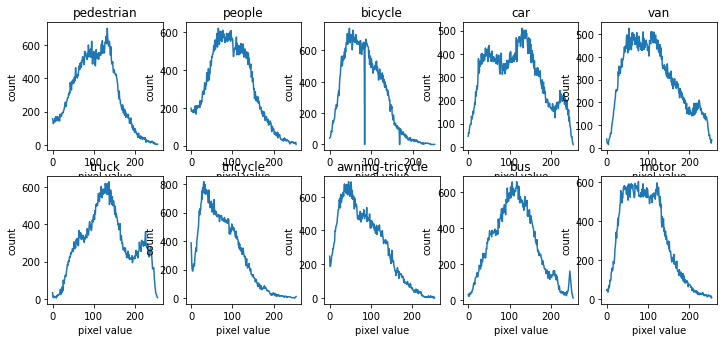

In [12]:
'''
Calculate the distribution of pixels contained within the bounding box of each class over a sample of 100 images
'''
dim = (16,16)
num_avg = 100

j = 0
for c in classes:
    df_class = df_labels[df_labels['label'] == c]
    avg_class = np.zeros((num_avg,dim[0],dim[1],3),dtype=np.float64)

    i = 0
    for idx,row in df_class[:num_avg].iterrows():
        img = cv2.imread(row['img_path'])

        y1 = int(row['y1'])
        y2 = int(row['y2'])
        x1 = int(row['x1'])
        x2 = int(row['x2'])
        car = img[y1:y2,x1:x2]

        avg_class[i] = cv2.resize(car,dim)
        i+=1
    j+=1

    if len(df_class) > 0:
        fig = plt.figure(num=1, figsize=(12, 8))
        # draw the corresponding histogram
        plt.subplot(3, 5, j-1)
        avg_class = avg_class.reshape(-1)
        histogram, bin_edges = np.histogram(avg_class, bins=256)
        plt.xlabel("pixel value")
        plt.ylabel("count")
        plt.plot(bin_edges[0:256], histogram)
        plt.title(c)


#### 12. Discuss what feature you would engineer (and implement) if using tabular data, what customized dataset augmentation you would use (not required to implement) if images, or what non-standard pre-processing might help, if text

Some dataset augmentation for the dataset images include image flipping, rotations, scaling, and cropping. Since the images are taken from a high angle, I think horizontal flipping, scaling, and cropping would make for the most realistic data augmentation.

In [13]:
'''
Augment the data by flipping horizontally
'''
augmenter = Augmenter()

#### 13. Separate your training data into features and labels.
The training data is already split into features (the images) and labels (the annotations).

#### 14. Discuss and implement how you will handle any dataset imbalance.

The high category imbalance of the dataset makes it difficult to identify the less common vehicles. Of the 10 categories, I think pedestrians and cars are most important, since they are also the most common objects in urban environments. Therefore, I do not think it is as important to get high accuracy on the less common vehicles like awning-tricycles.

A related issue is the high category imbalance between background and foreground objects. Since the detected object make up only a small fraction of the image (especially from high altitude images), there are many more background instances than objects. These background instances can overpower the loss function and prevent the model from learning from the foreground objects.

[Retinanet](https://arxiv.org/pdf/1708.02002.pdf) solves this issue by introducing a novel loss, dubbed Focal loss, which adds a factor to the standard cross entropy loss. The factor reduces the relative loss for well-classified examples and puts more focus on hard, misclassified examples. The original paper achieved a highly accurate object detector in the presence of vast numbers of easy background examples.

#### 15. Instantiate a model of your choosing.
#### 27. Instantiate any pre-trained model. Discuss why you chose it amongst the others.
I used retinanet models with a pre-trained resnet50 backbone on the COCO dataset. If I did not use pre-trained weights, the model would take a lot longer to converge since it is at least 50 layers deep.
#### 29. Replace the head of the model with sequential layer(s) to predict however many classes you need
This is done by setting the `num_classes` parameter in `model.resnet50(num_classes)`. Internally, this changes the dimensions of the final convolutional layers of the classification and bounding box regression subnetworks.


In [55]:
'''
Create an instance of retinanet with a resnet50 backbone
'''
def create_retinanet():
    retinanet = model.resnet50(num_classes=len(classes), pretrained=True)
    retinanet = retinanet.cuda()
    # Use dataparallel to split training on GPUs
    if torch.cuda.is_available():
        retinanet = torch.nn.DataParallel(retinanet).cuda()
    else:
        retinanet = torch.nn.DataParallel(retinanet)

    return retinanet


#### 30. What activation function did you use in the step above? Why?
This uses a Sigmoid activation function. We want the output of the model to be a probability between 0 and 1. The sigmoid function ranges from 0 to 1.
#### 31. Did you use dropout in the step above? Why or why not?
I did not use dropout as the authors of the retinanet paper did not use dropout. To select the best classifications, they instead only take the highest 1k predictions from the final classification layer and ignore the rest.
#### 32. Did you use batch normalization in the step above? Why or why not?
Yes. Batch normalization is used within resnet backbone. I did not alter how that works.

#### 16. Define a grid to tune at least three different hyperparameters with at least two different values each. Discuss why you think these parameter values might be useful for this dataset.
- Epochs: The number of times to train the model on the dataset
- Learning rate: The learning rate determines how much to adjust the weights based on the gradient. Finding the best learning rate helps the model converge onto the optimal set of weights.
- Batch size: The batch size is the number of images the model trains on before updating weights. Having too few images in the batch will make the model over fit to the image while having too many will prevent the model from learning specific characteristics from each image.
- Patience: This parameter is part of a scheduler which will decrease the learning rate once it has plateaued over `pateince` number of epochs. This helps improve the model by making finer adjustments to the weights.

In [56]:
grid = {
    'epochs': [1],
    'learning_rate': [0.001, 0.00001],
    'batch_size': [4,2], # batch_size < 5, or else CUDA out of memory
    'patience': [3,10]
}

#### 17. Set up a gridsearchCV with 5-fold cross validation (scikit-learn) or equivalent in PyTorch. Discuss what accuracy metric you chose and why.

In [57]:
'''
Define a train function to be used by cross validation
'''
def train(train_name,valid_name,epochs,learning_rate,batch_size,patience,model_name):
    csv_classes = 'classes.csv'
    # Create the data loader
    dataset_train = CSVDataset(train_file=train_name, class_list=csv_classes,transform=transforms.Compose([normalizer, augmenter, resizer]))

    if valid_name is None:
        dataset_val = None
        print('No validation annotations provided.')
    else:
        dataset_val = CSVDataset(train_file=valid_name, class_list=csv_classes,transform=transforms.Compose([normalizer, augmenter, resizer]))

    sampler = AspectRatioBasedSampler(dataset_train, batch_size=batch_size, drop_last=False)

    dataloader_train = DataLoader(dataset_train, num_workers=3, collate_fn=collater, batch_sampler=sampler)

    if dataset_val is not None:
        sampler_val = AspectRatioBasedSampler(dataset_val, batch_size=1,     drop_last=False)
        dataloader_val = DataLoader(dataset_val, num_workers=3, collate_fn=collater, batch_sampler=sampler_val)


    # Create the model
    retinanet = create_retinanet()

    retinanet.training = True

    optimizer = optim.Adam(retinanet.parameters(), lr=learning_rate)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, verbose=True)

    loss_hist = collections.deque(maxlen=500)


    retinanet.train()
    retinanet.module.freeze_bn()


    print('Num training images: {}'.format(len(dataset_train)))



    for epoch_num in range(epochs):

        retinanet.train()
        retinanet.module.freeze_bn()

        epoch_loss = []

        for iter_num, data in enumerate(dataloader_train):
            try:
                optimizer.zero_grad()

                if torch.cuda.is_available():
                    classification_loss, regression_loss = retinanet([data['img'].cuda().float(), data['annot']])
                else:
                    classification_loss, regression_loss = retinanet([data['img'].float(), data['annot']])

                classification_loss = classification_loss.mean()
                regression_loss = regression_loss.mean()

                loss = classification_loss + regression_loss

                if bool(loss == 0):
                    continue

                loss.backward()

                torch.nn.utils.clip_grad_norm_(retinanet.parameters(), 0.1)

                optimizer.step()

                loss_hist.append(float(loss))

                epoch_loss.append(float(loss))

                print(
                    'Epoch: {} | Iteration: {} | Classification loss: {:1.5f} | Regression loss: {:1.5f} | Running loss: {:1.5f}'.format(
                    epoch_num, iter_num, float(classification_loss), float(regression_loss), np.mean(loss_hist)))

                del classification_loss
                del regression_loss
            except Exception as e:
                print(e)
                continue


        if valid_name is not None:

            print('Evaluating dataset')

            mAP = csv_eval.evaluate(dataset_val, retinanet)

        scheduler.step(np.mean(epoch_loss))

        #torch.save(retinanet.module, 'trained_model/{}_epoch_{}.pt'.format(model_name, epoch_num))

    retinanet.eval()

    torch.save(retinanet, 'trained_model/{}_final.pt'.format(model_name))
    return mAP



In [58]:
'''
Helper function to split a CSV into folds
'''
def split_folds(csv,num_folds,iter):
    '''
    csv: csv file to split into folds
    num_folds: number of folds
    iter: 0-4 the current iteration
    '''
    df = pd.read_csv(csv,header=None,names=['img_path', 'x1', 'y1', 'x2', 'y2', 'label'])

    unique_paths = df['img_path'].unique()
    num = len(unique_paths)
    valid_size = int(num/num_folds)
    start_valid = valid_size * iter
    end_valid = start_valid + valid_size

    # get the image paths between start_valid and end_valid
    valid_paths = unique_paths[start_valid:end_valid]
    #valid = df[[df['img_path'].isin(valid_paths)]]
    valid = df[df['img_path'].isin(valid_paths)]
    train = df.drop(df.index[df['img_path'].isin(valid_paths)])

    return train, valid

'''
Implementation of gridsearchCV to run model on grid of parameters with cross validation
'''
def gridsearchCV(train_csv, grid):
    # split csv into 5 folds
    num_folds = 5

    # keep track of scores
    performances = []
    best_score = 0
    best_performance = ''

    for fold in range(num_folds):
        print('Starting Fold {}'.format(fold))

        train_df, valid_df = split_folds(train_csv, num_folds, fold)
        train_name = 'train_fold_{}'.format(fold)
        valid_name = 'valid_fold_{}'.format(fold)

        train_df.to_csv(train_name,header=False,index=False)
        valid_df.to_csv(valid_name,header=False,index=False)

        for epochs in grid['epochs']:
            for learning_rate in grid['learning_rate']:
                for batch_size in grid['batch_size']:
                    for patience in grid['patience']:
                        print('Parameters:')
                        print('\tEpochs: {}'.format(epochs))
                        print('\tLearning Rate: {}'.format(learning_rate))
                        print('\tBatch Size: {}'.format(batch_size))
                        print('\tPatience: {}'.format(patience))

                        model_name =     'model_fold-{}_e-{}_lr-{}_bs-{}_p-{}.pt'.format    (fold,epochs,learning_rate,batch_size,patience)
                        performance = {
                            'fold': i,
                            'epochs': epochs,
                            'learning_rate': learning_rate,
                            'batch_size': batch_size,
                            'patience': patience,
                            'model_name': model_name,
                            'score': 0
                        }

                        mAP = train(train_name,valid_name,epochs,learning_rate,batch_size,patience,model_name)

                        print(mAP)
                        #performance['score'] = score
                        #if score > best_score:
                        #    best_score = score
                        #best_performance = model_name

                    print('Performance: {}'.format(performance['score']))

    print(performances)
    print('Best performance: {}'.format(best_performance))



#### 18. Train your model using grid search (or equivalent), and report the best performing hyperparameters.

In [59]:
gridsearchCV('train.csv',grid)

Starting Fold 0
Parameters:
	Epochs: 1
	Learning Rate: 0.0001
	Batch Size: 2
	Patience: 1
Num training images: 1280
Epoch: 0 | Iteration: 0 | Classification loss: 1.13018 | Regression loss: 1.03347 | Running loss: 2.16365
Epoch: 0 | Iteration: 1 | Classification loss: 1.09720 | Regression loss: 1.12007 | Running loss: 2.19046
Epoch: 0 | Iteration: 2 | Classification loss: 1.03647 | Regression loss: 0.97756 | Running loss: 2.13165
Epoch: 0 | Iteration: 3 | Classification loss: 13.55121 | Regression loss: 1.08063 | Running loss: 5.25669
Epoch: 0 | Iteration: 4 | Classification loss: 0.54230 | Regression loss: 1.04107 | Running loss: 4.52203
Epoch: 0 | Iteration: 5 | Classification loss: 0.99374 | Regression loss: 1.16022 | Running loss: 4.12735
Epoch: 0 | Iteration: 6 | Classification loss: 1.04032 | Regression loss: 1.05660 | Running loss: 3.83729
Epoch: 0 | Iteration: 7 | Classification loss: 0.83412 | Regression loss: 1.00583 | Running loss: 3.58762
Epoch: 0 | Iteration: 8 | Classific

KeyboardInterrupt: 